In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount="True")

Mounted at /content/drive


In [3]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset/p1_movie_metadata.csv")
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


Perform EDA and Data Visualization

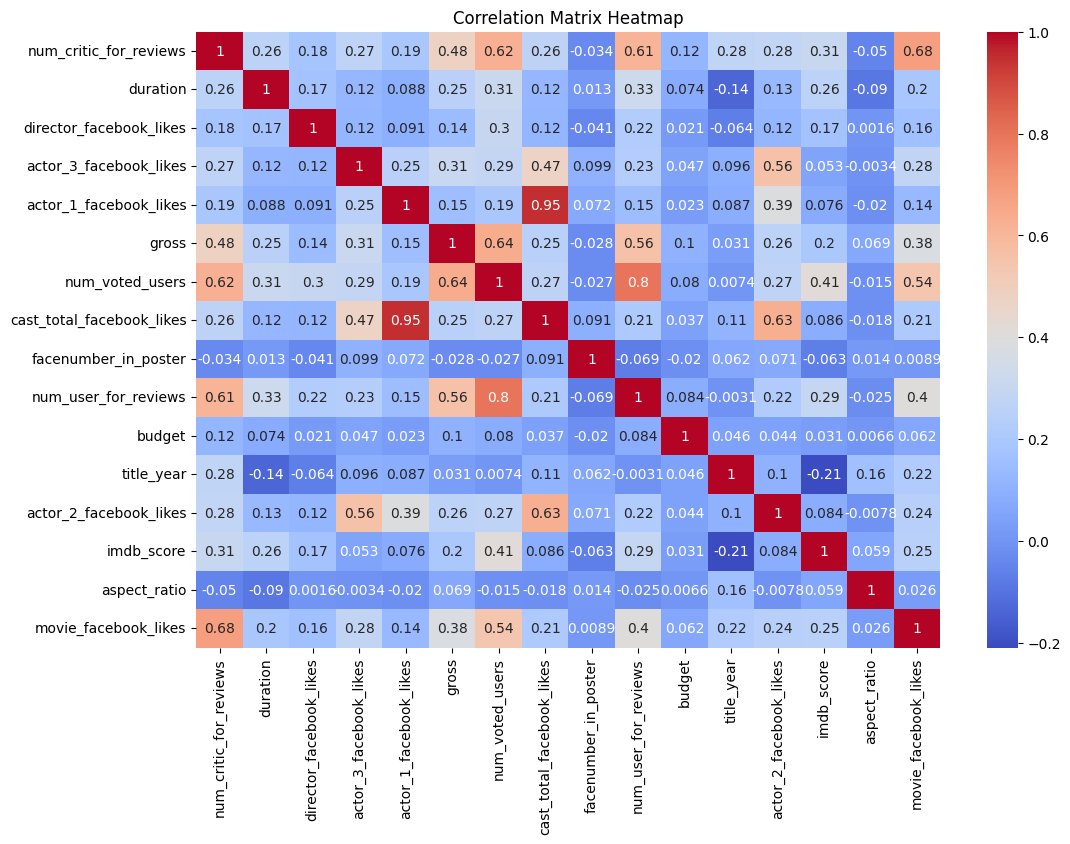

In [4]:
# Filter out non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Plot correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Feature Engineering

In [5]:
#Extracting release year from title_year
df.dropna(subset=['title_year'], inplace=True)
df['release_year'] = df['title_year'].astype('int')

#Encoding genres as binary variables
genres = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres], axis=1)

#Creating a feature for the length of plot_keywords
df['keywords_length'] = df['plot_keywords'].apply(lambda x: len(str(x).split('|')))


In [42]:
print(df.genres.value_counts)

<bound method IndexOpsMixin.value_counts of 0           Action|Adventure|Fantasy|Sci-Fi
1                  Action|Adventure|Fantasy
2                 Action|Adventure|Thriller
3                           Action|Thriller
5                   Action|Adventure|Sci-Fi
                       ...                 
5026                    Drama|Music|Romance
5027                                  Drama
5033                  Drama|Sci-Fi|Thriller
5035    Action|Crime|Drama|Romance|Thriller
5042                            Documentary
Name: genres, Length: 3755, dtype: object>


In [6]:
# print(df.isna().sum())
df.dropna(inplace=True)
print(df.isnull().sum())

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
movie_imdb_link              0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
release_year                 0
Action                       0
Adventure                    0
Animation                    0
Biograph

In [36]:
# Convert categorical variables to one-hot encoding
df_encoded = pd.get_dummies(df, columns=['color'])  # Assuming 'color' is a categorical variable

# Split data into train and test sets with encoded features
X_encoded = df_encoded.drop(['director_name', 'release_year', 'genres', 'plot_keywords'], axis=1)
y = df[['genres', 'title_year']]  # Target labels (genres and release year)
from sklearn.preprocessing import MultiLabelBinarizer

# Encode genres into numerical values
mlb = MultiLabelBinarizer()
y_genres_encoded = mlb.fit_transform(y['genres'])

# Combine encoded genres with release year
y_encoded = np.column_stack((y_genres_encoded, y['title_year']))
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Drop irrelevant non-numeric columns related to movie metadata
metadata_cols_to_drop = ['movie_title', 'movie_imdb_link']
X_train_encoded.drop(metadata_cols_to_drop, axis=1, inplace=True)
X_test_encoded.drop(metadata_cols_to_drop, axis=1, inplace=True)

# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train_encoded)
X_test_encoded = pd.get_dummies(X_test_encoded)

In [37]:
from sklearn.impute import SimpleImputer
# X_test_encoded = pd.get_dummies(X_test_encoded)
# Initialize SimpleImputer to fill missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train_encoded)

In [ ]:
# Get dummies for the test dataset with explicit columns
X_test_encoded = pd.get_dummies(X_test_encoded)

# Ensure that the test dataset has the same columns as the training dataset
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0  # Add missing columns and set their values to 0

# Reorder the columns to match the order in the training dataset
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Transform the test dataset using the previously fitted imputer
X_test_imputed = imputer.transform(X_test_encoded)

In [39]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Train a multi-output regression model for predicting both genres and release year
multioutput_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
multioutput_model.fit(X_train_imputed, y_train_encoded)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [45]:
# Example input features for prediction
input_features = X_test_imputed[0:1]

# Make prediction for genres and release year
predictions = multioutput_model.predict(input_features)

# Extract predicted genres and release year
predicted_genres = predictions[0][:len(mlb.classes_)]  # Extract the genre predictions
# Convert the predicted genres to a NumPy array
predicted_genres_array = np.array([predicted_genres])
genre_names = mlb.classes_

# Decode the predicted genres
predicted_genres_decoded = [genre_names[i] for i, value in enumerate(predicted_genres) if value == 1]

# Print the predicted genres and release year
print(f"Predicted Genres: {predicted_genres_decoded}")
print(f"Predicted Release Year: {predicted_release_year}")


Predicted Genres: ['A', 'D', 'H', 'R', 'a', 'c', 'd', 'e', 'i', 'm', 'n', 'o', 'r', 's', 't', 'u', 'v', 'y', '|']
Predicted Release Year: 1994.0


In [65]:
from sklearn.metrics import mean_squared_error,accuracy_score

# Predictions for training set
y_train_pred = multioutput_model.predict(X_train_imputed)
# Calculate MSE for training set
train_mse = mean_squared_error(y_train_encoded, y_train_pred)

# Predictions for testing set
y_test_pred = multioutput_model.predict(X_test_imputed)
# Calculate MSE for testing set
test_mse = mean_squared_error(y_test_encoded, y_test_pred)

#calculating accuracy for genre prediction
genre_accuracy = accuracy_score(y_test_encoded[:, 0], y_test_pred[:, 0])

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Genre Accuracy: {genre_accuracy}")


Train MSE: 0.0004953355122462995
Test MSE: 0.0013187911068070865
Genre Accuracy: 1.0


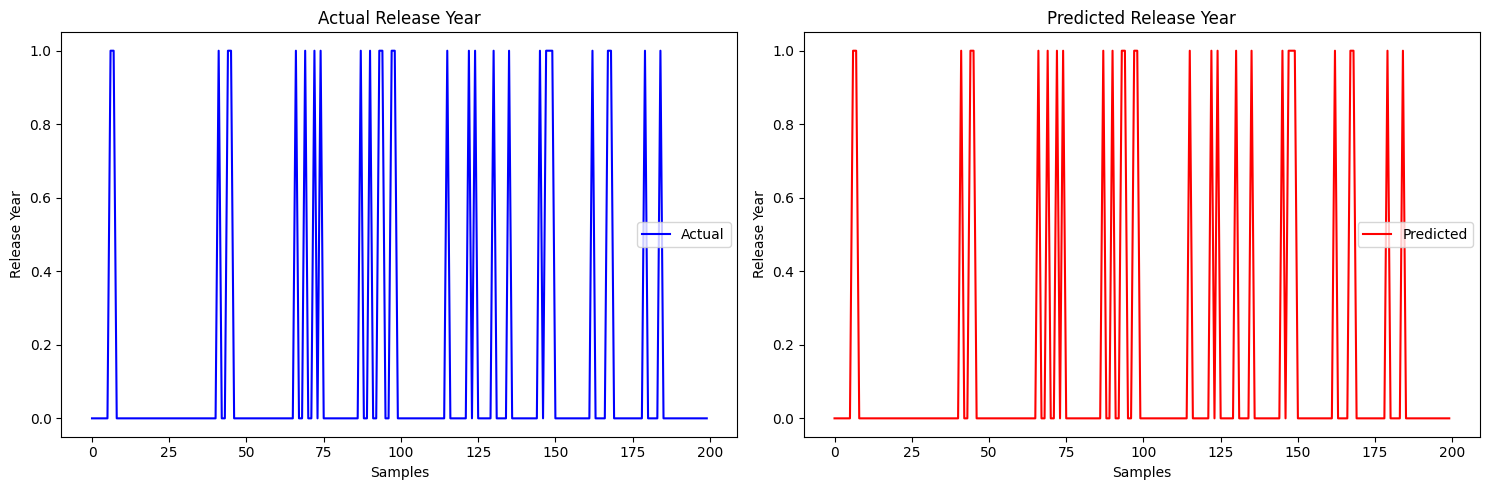

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Plot actual results
axs[0].plot(y_test_encoded[:200, 0], label='Actual', color='blue')
axs[0].set_title('Actual Release Year')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Release Year')
axs[0].legend()

# Plot predicted results
axs[1].plot(y_test_pred[:200, 0], label='Predicted', color='red')
axs[1].set_title('Predicted Release Year')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Release Year')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()